In [27]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

from google.cloud import bigquery
from google.oauth2 import service_account

In [28]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [29]:
sSheet=rf'ProyecciónValidarProy_Res'
# sSheet=rf'ProyecciónValidarProy_ResF'
pathfile=rf"C:\Alejo\Eje de Planeación\Análisis Energético\Ejecuciones 30 días\ValidaciónErrores\{sSheet}.csv"
df_proyIni = pd.read_csv(pathfile, delimiter=',',header=0,encoding="ISO-8859-1")
df_proyIni=df_proyIni[['Fecha','TipoDia','TBS_Total-GBTU','TCCC-GBTU']]
df_proyIni=df_proyIni.rename(columns={'TBS_Total-GBTU':'TBSTp','TCCC-GBTU':'TCDTp'})
df_proyIni['Fecha'] = pd.to_datetime(df_proyIni['Fecha']).dt.date
df_proyIni=df_proyIni.fillna(0)
df_proyIni

,Fecha,TipoDia,TBSTp,TCDTp
0,2025-10-19,F,48.769078,34.299652
1,2025-10-20,O,49.039162,38.219662
2,2025-10-21,O,51.465290,33.843037
3,2025-10-22,O,38.844009,39.384289
4,2025-10-23,O,51.418530,34.446763
...,...,...,...,...
128,2026-02-24,O,51.091874,12.067265
129,2026-02-25,O,46.977818,29.509877
130,2026-02-26,O,49.400299,25.560301
131,2026-02-27,O,59.284141,25.357916


In [30]:
FechaIni=pd.to_datetime(df_proyIni['Fecha']).min()
FechaFin=pd.to_datetime(df_proyIni['Fecha']).max()

In [31]:
# Consulta a la maestra de recursos
query = rf"""
SELECT * FROM `enersinc-tbsg-bq`.tbsg.public_ddec 
where fechaoperacion>='{FechaIni.strftime('%Y-%m-%d')}' and fechaoperacion <='{FechaFin.strftime('%Y-%m-%d')}' and nombre in ('TEBSAB CC','TERMOCANDELARIA CC','BARRANQUILLA 3','BARRANQUILLA 4')
order by fechaoperacion ,nombre
"""

# Ejecutar la consulta
df_GenDIni = client.query(query).to_dataframe()

query = rf"""
SELECT * FROM `enersinc-tbsg-bq`.tbsg.public_dconfig
where fechaoperacion>='{FechaIni.strftime('%Y-%m-%d')}' and fechaoperacion <='{FechaFin.strftime('%Y-%m-%d')}' and recurso in ('TEBSAB CC','TERMOCANDELARIA CC')
order by fechaoperacion ,recurso 
"""

# Ejecutar la consulta
df_ConfDIni = client.query(query).to_dataframe()

In [32]:
df_GenD=df_GenDIni.copy()
df_ConfD=df_ConfDIni.copy()

for i in range(1,25):
    df_GenD = df_GenD.rename(columns={f'hora{i}': i})
    if i<10:
        df_ConfD = df_ConfD.rename(columns={f'p0{i}': i})
    else:
        df_ConfD = df_ConfD.rename(columns={f'p{i}': i}) 


df_GenD = df_GenD.melt(id_vars=['fechaoperacion', 'nombre', 'version'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='gen')

df_ConfD = df_ConfD.melt(id_vars=['fechaoperacion', 'recurso', 'version'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='conf')

df_GenD['nombre'] = df_GenD['nombre'].replace({'BARRANQUILLA 3': 'TEBSAB CC', 'BARRANQUILLA 4': 'TEBSAB CC'})
df_GenD=df_GenD.groupby(['fechaoperacion','nombre','periodo'])[['gen']].sum().reset_index().round(2)

df_GenD=df_GenD.merge(df_ConfD,left_on=['fechaoperacion','nombre','periodo'],right_on=['fechaoperacion','recurso','periodo'], 
                        how='inner')[['fechaoperacion','recurso','periodo','gen','conf']]

df_GenD = df_GenD.pivot(index=['fechaoperacion','periodo'], columns='recurso', values=['gen','conf']).reset_index()

df_GenD.to_csv('DataGenDespacho.csv')
df_GenD

fechaoperacion periodo       gen                         conf  \
recurso                        TEBSAB CC TERMOCANDELARIA CC TEBSAB CC   
0           2025-10-19       1     210.0              330.0         2   
1           2025-10-19       2     210.0              330.0         2   
2           2025-10-19       3     210.0              176.0         2   
3           2025-10-19       4     210.0              125.0         2   
4           2025-10-19       5    239.44                0.0         2   
...                ...     ...       ...                ...       ...   
1387        2025-12-15      20     283.0             342.22         6   
1388        2025-12-15      21     283.0             392.21         6   
1389        2025-12-15      22     210.0             338.59         2   
1390        2025-12-15      23     210.0             331.84         2   
1391        2025-12-15      24     210.0              330.0         2   

                            
recurso TERMOCANDELARIA CC  
0                        4  
1                        4  
2                        3  
3                        1  
4                        0  
...                    ...  
1387                     4  
1388                     4  
1389                     4  
1390                     4  
1391                     4  

[1392 rows x 6 columns]

In [33]:
FechaIni=dt.date(FechaIni.year, FechaIni.month, FechaIni.day)
FechaFin=dt.date(FechaFin.year, FechaFin.month, FechaFin.day)

In [34]:
# Consutlar combustible
df_Comb= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ConsCombustibleMBTU",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_Comb.rename(columns={'Values_code':'planta'},inplace=True)
df_Comb=df_Comb.fillna(0)

In [35]:
df_CombIni=df_Comb.copy()
df_CombIni=df_CombIni[(df_CombIni['planta'].isin(['TBST','TBQ3','TBQ4','TCD2','TCD1','TCDT']))]

df_CombIni['TotalDia']=0
l_per=[]
for i in range(1,25):
    if i<10:
        l_per.append('Values_Hour0' + str(i))
    else:
        l_per.append('Values_Hour' + str(i))


for col in l_per:
    df_CombIni['TotalDia']=df_CombIni['TotalDia']+df_CombIni[col]

df_CombIni=df_CombIni[['Date','planta','TotalDia']]
df_CombIni['TotalDia']=round(df_CombIni['TotalDia']/1000,2)

df_CombIni['planta'] = df_CombIni['planta'].replace({'TBQ3': 'TBST', 'TBQ4': 'TBST'})
df_CombIni['planta'] = df_CombIni['planta'].replace({'TCD2': 'TCDT', 'TCD1': 'TCDT'})

df_CombIni=df_CombIni.groupby(['Date','planta'])[['TotalDia']].sum().reset_index().round(2)

df_CombIni['Date'] = df_CombIni['Date'].dt.date

df_CombIni = df_CombIni.pivot(index='Date', columns='planta', values='TotalDia').reset_index()

In [36]:
df_CombIni

planta,Date,TBST,TCDT
0,2025-10-19,62.66,39.05
1,2025-10-20,65.09,55.74
2,2025-10-21,71.94,36.08
3,2025-10-22,76.89,34.91
4,2025-10-23,70.49,19.45
5,2025-10-24,66.05,37.40
6,2025-10-25,30.95,38.01
7,2025-10-26,61.15,38.98
8,2025-10-27,77.34,37.47
9,2025-10-28,48.20,62.86


In [37]:
df_proy=df_proyIni.copy()
df_proy=df_proy.merge(df_CombIni,left_on=['Fecha'],right_on=['Date'], how='inner')[['Fecha','TipoDia','TBSTp','TCDTp','TBST','TCDT']]
df_proy['TB_Dif_GBTU']=df_proy['TBST']-df_proy['TBSTp']
df_proy['TC_Dif_GBTU']=df_proy['TCDT']-df_proy['TCDTp']
df_proy['TB_%']=100*(df_proy['TB_Dif_GBTU']/df_proy['TBSTp'])
df_proy['TC_%']=100*(df_proy['TC_Dif_GBTU']/df_proy['TCDTp'])
# Eliminar filas entre 2025-10-10 y 2025-10-14 (inclusive)
start = pd.to_datetime('2025-10-10').date()
end = pd.to_datetime('2025-10-17').date()
df_proy['Fecha'] = pd.to_datetime(df_proy['Fecha']).dt.date
df_proy = df_proy.loc[~df_proy['Fecha'].between(start, end)].reset_index(drop=True)
df_proy
df_proy.to_csv('Consumo.csv')

In [38]:
df_proy_tipodia=df_proy.groupby(['TipoDia'])[['TB_%','TC_%']].mean().reset_index()
df_proy_tipodia

,TipoDia,TB_%,TC_%
0,F,183.989547,35.804959
1,O,92.073795,25.624013
2,S,95.142922,6.518295


Medias de las series de datos:
TB_Dif_GBTU: 29.550309483118124
TC_Dif_GBTU: 7.385384102245763
TB_%: 111.19522414384129
TC_%: 25.22124203861144
Desviaciones standar de las series de datos:
TB_Dif_GBTU: 21.273868698123167
TC_Dif_GBTU: 11.675722155602491
TB_%: 137.71872173759095
TC_%: 38.51742224387561
Resultados de ajuste para TB_Dif_GBTU:
  norm: KS-Stat=0.1063, p-value=0.5397
  expon: KS-Stat=0.1976, p-value=0.0253
  uniform: KS-Stat=0.1974, p-value=0.0256
  gamma: KS-Stat=0.0511, p-value=0.9976
  beta: KS-Stat=0.0806, p-value=0.8468
Resultados de ajuste para TC_Dif_GBTU:
  norm: KS-Stat=0.1073, p-value=0.5283
  expon: KS-Stat=0.2719, p-value=0.0005
  uniform: KS-Stat=0.1553, p-value=0.1326
  gamma: KS-Stat=0.0716, p-value=0.9258
  beta: KS-Stat=0.1013, p-value=0.6003
Resultados de ajuste para TB_%:
  norm: KS-Stat=0.2877, p-value=0.0002
  expon: KS-Stat=0.2149, p-value=0.0115
  uniform: KS-Stat=0.5364, p-value=0.0000
  gamma: KS-Stat=0.1779, p-value=0.0576
  beta: KS-Stat=0.2195, p-va

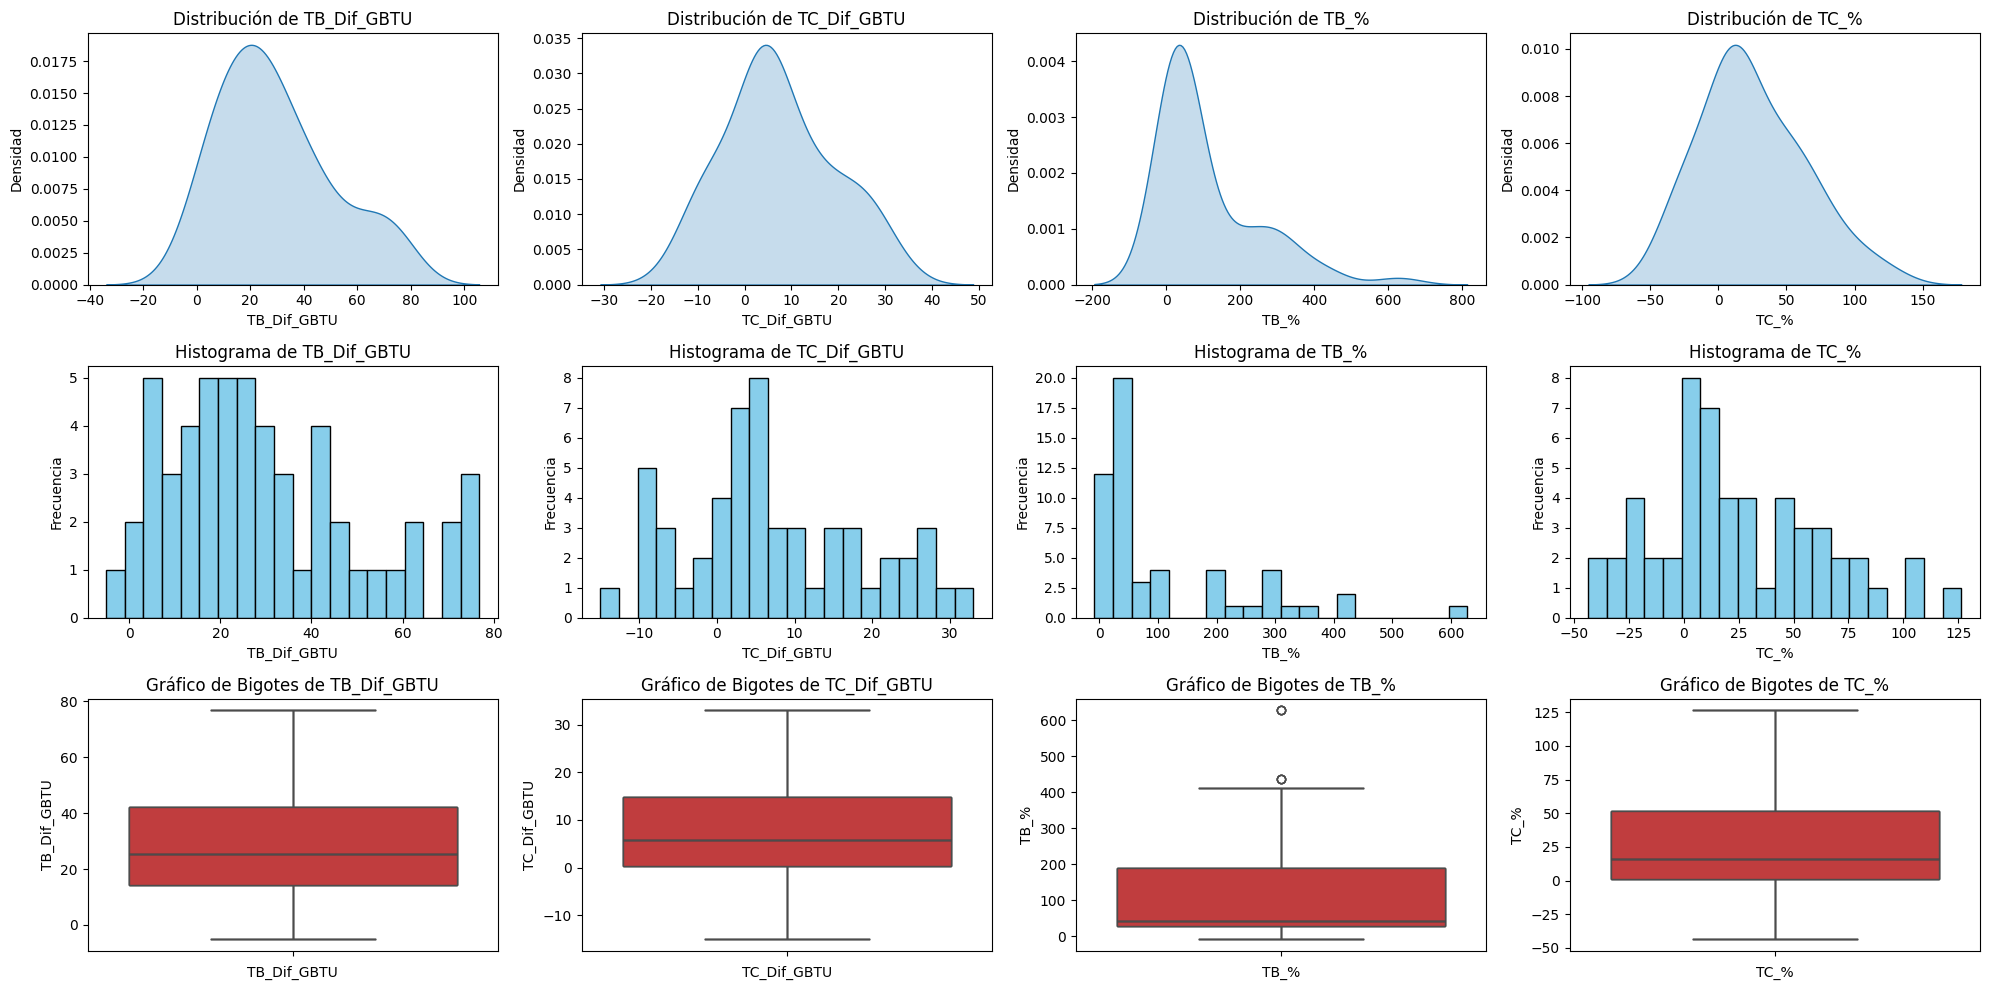

In [39]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# Configuración de la figura
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Columnas a graficar
columns = ['TB_Dif_GBTU', 'TC_Dif_GBTU', 'TB_%', 'TC_%']

# Graficar distribuciones de probabilidad
for i, col in enumerate(columns):
    sns.kdeplot(df_proy[col], ax=axes[0, i], fill=True)
    axes[0, i].set_title(f'Distribución de {col}')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Densidad')

# Graficar histogramas de frecuencias
for i, col in enumerate(columns):
    axes[1, i].hist(df_proy[col], bins=20, color='skyblue', edgecolor='black')
    axes[1, i].set_title(f'Histograma de {col}')
    axes[1, i].set_xlabel(col)
    axes[1, i].set_ylabel('Frecuencia')

    # Graficar gráficos de bigotes
    means = {}
    stds={}
    fit_results = {}
    for i, col in enumerate(columns):
        sns.boxplot(data=df_proy, y=col, ax=axes[2, i])
        axes[2, i].set_title(f'Gráfico de Bigotes de {col}')
        axes[2, i].set_xlabel(col)
        axes[2, i].set_ylabel(col)
        means[col] = df_proy[col].mean()
        stds[col] = df_proy[col].std()


        # Validar el ajuste a distribuciones comunes
        distributions = ['norm', 'expon', 'uniform', 'gamma', 'beta']
        

        fit_results[col] = {}
        for dist_name in distributions:
            dist = getattr(stats, dist_name)
            params = dist.fit(df_proy[col])
            ks_stat, p_value = stats.kstest(df_proy[col], dist_name, args=params)
            fit_results[col][dist_name] = {'ks_stat': ks_stat, 'p_value': p_value}



# Mostrar las medias calculadas
print("Medias de las series de datos:")
for col, mean in means.items():
    print(f"{col}: {mean}")

print("Desviaciones standar de las series de datos:")
for col, std in stds.items():
    print(f"{col}: {std}")

# Mostrar los resultados de ajuste
for col, results in fit_results.items():
    print(f"Resultados de ajuste para {col}:")
    for dist_name, metrics in results.items():
        print(f"  {dist_name}: KS-Stat={metrics['ks_stat']:.4f}, p-value={metrics['p_value']:.4f}")

# Ajustar el diseño
plt.tight_layout()
plt.show()